# Major League Baseball Game Logs, Generaliized Linear Model

*The information used here was obtained free of charge from and is copyrighted by Retrosheet.  Interested parties may contact Retrosheet at "www.retrosheet.org".*

## 1. Introduction

Major League Baseball game logs are a per-game summary of the events that occur during a single game in the form of counting statistics. In an earlier analysis, we examined the effect of these events by fitting a linear regression model to the number of runs scored. The resulting model produced coefficient estimates that appear reasonable, however the diagnostic measures revealed potential problems. Specifically, there was evidence of non-linear behavior in the response, heteroskedasticity, and multicollinearity among the regressors. The resulting model, therefore, is subject to biased coefficient estimates and unreliable confidence intervals. This project will address those problems by fitting a generalized linear model (GLM) to the number of runs scored and compare the results to the ordinary least squares (OLS) model.

Recall that a GLM relates the conditional mean $E(Y|X=x)$ to a linear predictor $\beta_0 + \beta_1 x_1 + ... + \beta_i x_i$ through a linking function, denoted $g()$. That is, 

$$ g(E(Y|X_i = x_i)) = \beta_0 + \beta_1 x_1 + ... + \beta_i x_i$$
or 
$$E(Y|X_i = x_i) = g^{-1} (\beta_0 + \beta_1 x_1 + ... + \beta_i x_i)
$$

where $i$ is the number of independent variables. The model depends on the response distribution as well as the linking function. As a prelude to this analysis, we also examined the distribution of the game-log statistics in an earlier project. The various lengths of games (extra innings or rain-shortened) in the data set causes over dispersion and, as a result, the negative binomial distribution was the preferred method to model the counts. When over dispersion was not an issue, the Poisson and binomial distributions performed reasonably well. These appear to be the prime candidates for our model. We will also include the Gaussian distribution as a point of comparison to the OLS model from an earlier project.

The choice of linking function is perhaps as important to the results of the model as the choice of the distribution for the response. We will be using the Statsmodels API for this analysis and for each response distribution there are several choices for the link function. The data set is relatively small and the time to compute the results is small enough that we will fit each of them and sort through the results to select the best model.


## 2. Motivation

The primary motivation for this project is to fit a GLM to the MLB game log data set and infer the value each variable with respect to the number of runs scored. We will compare these results to those obtained from an OLS regression model developed in an earlier project and decide which model is more appropriate for making statistical inferences. Finally, we will determine if a GLM addresses the problems discovered in the OLS model.

We will use the same data set, with the following variables.

**Offensive Categories**
- *season*: Season in which game is played (year).
- *league*: League of the home team.
- *win*: Indicator of win or loss.
- *score*: Number of runs scored by a team's offense.
- *ab*: Number of at-bats for a team's offense. An official at-bat comes when a batter reaches base via a fielder's choice, hit or an error (not including catcher's interference) or when a batter is put out on a non-sacrifice.
- *1b*: Number singles for a team's offense.
- *2b*: Number of doubles for a team's offense.
- *3b*: Number of triples for a team's offense.
- *4b*: Number of home runs for a team's offense.
- *sach*: Number of sacrifice hits (or sacrifice bunts) for a team's offense. A sacrifice bunt occurs when a player is successful in his attempt to advance a runner (or multiple runners) at least one base with a bunt.
- *sacf*: Number of sacrifice flies for a team's offense. A sacrifice fly occurs when a batter hits a fly-ball out to the outfield or foul territory that allows a runner to score. The batter is given credit for an RBI.
- *hbp*: Number of hit-by-pitches for a team's offense. A hit-by-pitch occurs when a batter is struck by a pitched ball without swinging at it. He is awarded first base as a result. Strikes supersede hit-by-pitches, meaning if the umpire rules that the pitch was in the strike zone or that the batter swung, the HBP is nullified.
- *bb*: Number of base-on-balls (walks) for a team's offense. A walk (or base on balls) occurs when a pitcher throws four pitches out of the strike zone, none of which are swung at by the hitter. After refraining from swinging at four pitches out of the zone, the batter is awarded first base. In the scorebook, a walk is denoted by the letters BB.
- *ibb*: Number of intentional base-on-balls (walks) for a team's offense. An intentional walk occurs when the defending team chooses to walk a batter on purpose, putting him on first base instead of letting him try to hit.
- *k*: Number of strikeouts for a team's offense.
- *sb*: Number of stolen bases for a team.
- *cs*: Number of caught stealing for a team.
- *gidp*: Number of grounded-into-double-plays for a team's offense. A GIDP occurs when a player hits a ground ball that results in multiple outs on the bases.
- *ci*: Number of catcher's interference awarded to a teams' offense. The batter is awarded first base if the catcher (or any other fielder) interferes with him at any point during a pitch. If first base was occupied at the time of the pitch, the runner who held the base is allowed to move up one base.
- *lob*: The total number (over the course of a game) of runners left on base at the end of each inning by a team's offense.

**Defensive Categories**

- *oppNumPitchers*: Number of pitchers appearing in the for the opponent's defense.
- *oppER*: Number of earned runs surrendered by the opponent's defense. An earned run is any run that scores against a pitcher without the benefit of an error or a passed ball.
- *oppTeamER*: Number of earned runs surrendered by the opponent's defense that is not assigned to a specific pitcher.
- *oppWP*: Number of wild pitches surrendered by the opponent's defense. A pitcher is charged with a wild pitch when his pitch is so errant that the catcher is unable to control it and, as a result, baserunner(s) advance.
- *oppBalk*: Number of balks surrendered by the opponent's defense. A balk occurs when a pitcher makes an illegal motion on the mound that the umpire considers to be deceitful to the runner(s).
- *oppPO*: Number of putouts recorded by the opponent's defense. A fielder is credited with a putout when he is the fielder who physically records the act of completing an out -- whether it be by stepping on the base for a force out, tagging a runner, catching a batted ball, or catching a third strike.
- *oppAssist* Number of assists recorded by the opponent's defense. An assist is awarded to a fielder who touches the ball before a putout is recorded by another fielder. Typically, assists are awarded to fielders when they throw the ball to another player -- but a fielder receives an assist if he touches the ball, even if the contact was unintentional.
- *opERR*: Number of errors recorded by the opponent's defense. A fielder is given an error if, in the judgment of the official scorer, he does not convert an out on a play that an average fielder should have made. Fielders can also be given errors if they make a poor play that allows one or more runners to advance on the bases.
- *oppPB*: Number of passed balls recorded by the opponent's defense. A catcher is charged with a passed ball when he does not hold or control a legally pitched ball that, with ordinary effort, should have been maintained under his control, and, because of this loss of control, the batter, or a runner on base advances. A runner who advances due to a passed ball is not credited with a stolen base unless he breaks for the base before the pitcher begins his delivery.
- *oppDP*: Number of double plays recorded by the opponent's defense. A double play occurs when two offensive players are ruled out within the same play.
- *oppTP*: Number of triple plays recorded by the opponent's defense. A triple play occurs when three offensive players are ruled out within the same play.


## 3. Analysis

### 3.1 Imports and Function Definitions

In [ ]:
import warnings
# suppress keyword-only future warnings in pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import random
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import itertools
import json
from google.colab import drive

Define convenience functions to (1) perform the split of the training, testing, and validation data, (2) create the diagnostic plot for a fitted model, and (3) calculate the variance inflation factor (VIF) and condition number for the proposed design matrix.

In [ ]:
def ttvSplit (ixIn, splitsIn=[0.8,0.1,0.1], shuffle_list=True):
    """
    Parameters
    ----------
    ixIn : List or list-like object.
        A list of indices for the data frame.
    splitsIn : List or list-like object, optional
        Proportions of ixIn in each split. If the proportions do not sum to 1,
        they will be automatically scaled. The default is [0.1,0.1,0.8].
    shuffle_list: Boolean.
        Indicator if the incoming list should be randomly shuffled.

    Returns
    -------
    A ragged list of indices for the training, testing, and validation data sets.

    """

    ixIn = list(ixIn)

    if shuffle_list==True:
        random.shuffle(ixIn)

    splitsIn = list(splitsIn)

    #define break points
    splits0 = [0]+[int(i) for i in np.rint(len(ixIn)*np.array(splitsIn).cumsum()/np.array(splitsIn).sum())]

    #ragged list of partitions
    splitsOut = [ixIn[splits0[i]:splits0[i+1]] for i in range(len(splits0)-1)]

    return(splitsOut)

def plotGLMResidualsHist(resGLM, figureSize=(10,5),plotTitle=''):
    """
    Parameters
    ----------
    results : statsmodels.genmod.generalized_linear_model.GLMResultsWrapper
        The results from fitting a GLM.
    figureSize: tuple
        The dimensions (inches) of the resulting plot. Default is 10 x 5
    plotTitle: string
        Title of the figure. Default is ''

    Returns
    -------
    Two panel histogram of the Pearson and deviance residuals.

    """
    # hist of pearson/deviance residuals
    fig = plt.figure(figsize=figureSize, tight_layout=False)
    fig.suptitle(plotTitle,fontweight='bold')
    ax0 = plt.subplot(1,2,1)
    sns.histplot(resGLM.resid_deviance,stat='density',kde=True, alpha=0.25, ax=ax0)
    ax0.plot(np.linspace(-7,7,100),
             scipy.stats.norm.pdf(np.linspace(-7,7,100),
                                  resGLM.resid_deviance.mean(),
                                  resGLM.resid_deviance.std()),
             color='green')

    ax0.set_title('Deviance Residuals')
    ax0.legend(['KDE','Normal'])
    ax1 = plt.subplot(1,2,2)
    sns.histplot(resGLM.resid_pearson,stat='density',kde=True, alpha=0.25, ax=ax1)
    ax1.plot(np.linspace(-7,7,100),
             scipy.stats.norm.pdf(np.linspace(-7,7,100),
                                  resGLM.resid_pearson.mean(),
                                  resGLM.resid_pearson.std()),
             color='green')

    ax1.set_title('Pearson Residuals')
    ax1.legend(['KDE','Normal'])
    return()

def glmDiagnosticPlots(glmResults, figureSize=(10,10), figureTitle=''):
    """
    Parameters
    ----------
    glmResults : statsmodels.genmod.generalized_linear_model.GLMResultsWrapper
        Results from a fitted glm model (statsmodels).
    figureSize : Tuple, optional
        Dimensions of the figure. The default is (10,10).
    figureTitle : String, optional
        Title of the figure. The default is ''.

    Returns
    -------
    Fig.
    matplotlib.figure.Figure
    Four panel diagnostic plots for GLM regression

    """

    # step 1. unpack model results
    yTrue = glmResults.model.endog
    yHat = glmResults.fittedvalues
    X = glmResults.model.exog
    XNames = glmResults.model.exog_names

    residuals = np.array(glmResults.resid_deviance)
    influence = glmResults.get_influence()
    residNorm = influence.resid_studentized
    residNormAbsSqrt = np.sqrt(np.abs(residNorm))
    leverage = influence.hat_matrix_diag
    cooksDistance = influence.cooks_distance[0]
    numParams = len(glmResults.params)


    # Step 2. Calc Cooks distance reference lines
    formula0 = lambda x: np.sqrt((0.5 * numParams * (1 - x)) / x)
    cooksDistx0 = np.linspace(0.001, max(leverage), 50)
    cooksDisty0 = formula0(cooksDistx0)

    formula1 = lambda x: np.sqrt((1.0 * numParams * (1 - x)) / x)
    cooksDistx1 = np.linspace(0.001, max(leverage), 50)
    cooksDisty1 = formula1(cooksDistx1)

    fig = plt.figure(figsize=figureSize,tight_layout=False)
    fig.suptitle(figureTitle,fontweight='bold')

    ## Step 3. Create Plots
    # Residuals vs fitted plot
    ax0 = plt.subplot(2,2,1)
    sns.residplot(x=yHat,
                  y=residuals,
                  lowess=True,scatter_kws={'alpha': 0.25},
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                  ax=ax0)
    ax0.set_title('Deviance Residuals vs. Fitted',fontweight='bold')
    ax0.set_xlabel('Fitted')
    ax0.set_ylabel('Deviance Residuals')

    # QQ plot
    ax1 = plt.subplot(2,2,2)
    QQ = ProbPlot(residNorm)
    QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax1)
    ax1.set_title('Normal QQ', fontweight="bold")
    ax1.set_xlabel('Theoretical Quantiles')
    ax1.set_ylabel('Standardized Residuals')

    # Scale-Location plot
    ax2 = plt.subplot(2,2,3)
    ax2.scatter(yHat, residNormAbsSqrt, alpha=0.25);
    sns.regplot(
        x=yHat,
        y=residNormAbsSqrt,
        scatter=False, ci=False,
        lowess=True,
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
        ax=ax2)
    # annotate plot with top 5 residuals
    for i in np.argsort(residNormAbsSqrt,0)[-5:]:
        ax2.annotate(i,
                     xy=(yHat.iloc[i],residNormAbsSqrt[i]),
                     color='red')

    ax2.set_title('Scale-Location', fontweight="bold")
    ax2.set_xlabel('Fitted values')
    ax2.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$')

    #Leverage Plot
    ax3 = plt.subplot(2,2,4)
    ax3.set_xlim(0,1.1*max(leverage))
    ax3.scatter(
                leverage,
                residNorm,
                alpha=0.5)

    sns.regplot(
        x=leverage,
        y=residNorm,
        scatter=False,
        ci=False,
        lowess=True,
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
        ax=ax3)

    # annotations
    for i in np.argsort(cooksDistance,0)[-5:]:
        ax3.annotate(
            i,
            xy=(leverage[i], residNorm[i]),
            color = 'red')

    # Cooks distance 0.5 reference line
    ax3.plot(cooksDistx0, cooksDisty0, label="Cook's distance", lw=1, ls='--', color='red')
    ax3.plot(cooksDistx1, cooksDisty1, lw=1, ls='--', color='red')

    ax3.set_title('Residuals vs Leverage', fontweight="bold")
    ax3.set_xlabel('Leverage')
    ax3.set_ylabel('Standardized Residuals')
    ax3.legend(loc='upper right')

    return(fig)

def calcVIFCond(exog, verbose=True):
    """
    Parameters
    ----------
    exog : Pandas dataframe
        The design matrix for the features under consideration.

    Returns
    -------
    Variance inflation factor and condition number for exog.

    """

    vifDict= {}
    if verbose==True:
        print('VIF')
    for c in range(len(exog.columns)):
        try:
            vifDict[exog.columns[c]] = VIF(exog.to_numpy(),c)
            if verbose==True:
                print('\t',exog.columns[c],(20-len(exog.columns[c]))*" ",vifDict[exog.columns[c]])
        except TypeError as te:
            print(te)

    condNum = np.linalg.cond(exog.dropna())

    if verbose==True:
        print(f'\nCondition Number: {condNum}\n')

    return(vifDict, condNum)

### 3.2 Load Data and Prepare the Data Frame

Load the data from a *CSV* file.

In [ ]:
# load data without index column
df = pd.read_csv('https://github.com/cmtoner/retrosheets-game-logs/raw/main/rs_GameLog_data02.zip', index_col=0)

df.head()

# drop seasons less than 1920 and game with score>15
df = df[(df.season>=1920)&(df.score<=15)]

df.head()

,season,league,win,score,ab,1b,2b,3b,4b,sach,...,oppER,oppTeamER,oppWP,oppBalk,oppPO,oppAssist,oppERR,oppPB,oppDP,oppTP
0,1933,ML,1,4,31.0,8.0,0.0,0.0,1.0,1.0,...,4.0,4.0,0.0,0.0,24.0,11.0,0.0,0.0,1.0,0.0
1,1935,ML,1,4,32.0,4.0,2.0,1.0,1.0,0.0,...,4.0,4.0,0.0,0.0,24.0,8.0,1.0,0.0,0.0,0.0
2,1937,ML,1,8,35.0,8.0,3.0,1.0,1.0,0.0,...,8.0,8.0,0.0,0.0,24.0,9.0,0.0,0.0,1.0,0.0
3,1939,ML,1,3,31.0,5.0,0.0,0.0,1.0,0.0,...,2.0,2.0,0.0,0.0,24.0,7.0,1.0,0.0,0.0,0.0
4,1941,ML,1,7,36.0,7.0,3.0,0.0,1.0,0.0,...,7.0,7.0,0.0,0.0,26.0,7.0,2.0,0.0,1.0,0.0


Split the data frame indices into training, testing, and validation indices. We will slice the data frame using these indices rather than defining new data frames each time it is needed.

In [ ]:
#get Training, Testing, and validation indices
ixTr, ixTe, ixV = ttvSplit(df.dropna().index, splitsIn=[0.60,0.20,0.20])


Drop features based on our earlier (OLS) analysis. We are not concerned with prediction as much as we are making good statistical inferences. League, for example, may be significant in predicting the final score of a game, but membership in a league is not an event that directly leads to run scoring in a game. Similarly, the season will be dropped. Rule changes or prevailing game strategies may be latent properties hidden within *season* and not measured, otherwise. This project, however, is only concerned with quantifying the value of, say, a double or a walk. Any variable that is not an on-field event is omitted.

In [ ]:
# eliminate features based on previous analysis
# define columns of interest
xCols0 = ['ab','1b','2b','3b','4b','sach','sacf','hbp','bb','ibb','k','sb',
          'cs','gidp','ci','oppWP','oppBalk','oppERR','oppPB','oppTP']

#look for null values in each column of interest
for c in xCols0:
    if any(pd.isnull(df.loc[ixTr,c]))>0:
        print(c)
    else:
        print(f'{c}: No null values present.')

ab: No null values present.
1b: No null values present.
2b: No null values present.
3b: No null values present.
4b: No null values present.
sach: No null values present.
sacf: No null values present.
hbp: No null values present.
bb: No null values present.
ibb: No null values present.
k: No null values present.
sb: No null values present.
cs: No null values present.
gidp: No null values present.
ci: No null values present.
oppWP: No null values present.
oppBalk: No null values present.
oppERR: No null values present.
oppPB: No null values present.
oppTP: No null values present.


### 3.3 Correlation Matrix

Examine the correlation matrix, looking for large correlations (positive or negative) among the potential regressors. The variables *gidp* and *oppDP* are both counting double-plays, so *oppDP* will be eliminated. Likewise, for *oppER* and *oppTeamER*, so they will be eliminated.

The variables *oppNumPitches*, *lob*, *season*, and *win* are not events that result in run scoring, so they are eliminated. On the defensive side, *oppPO* and *oppAssist* are certainly not independent of each other or variables such as *k* and *ab*, so they are also eliminated.


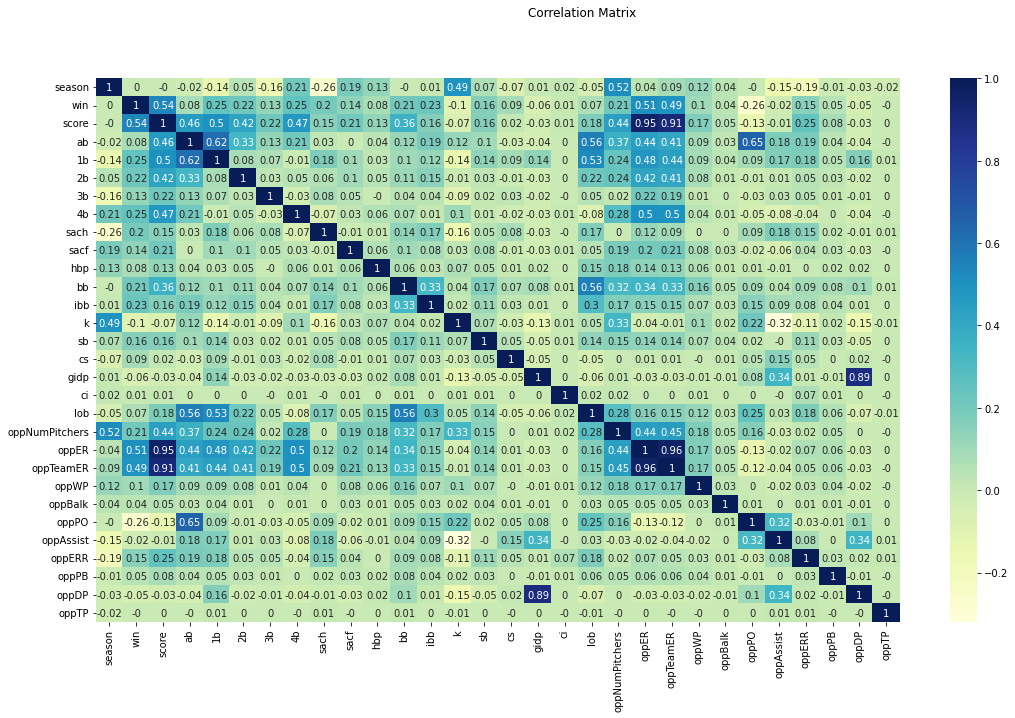

In [ ]:
#plot corr matrix
fig0 = plt.figure(figsize=(18,10), tight_layout=False)
fig0.suptitle('Correlation Matrix')
sns.heatmap(round(df.corr(),2),
            cmap="YlGnBu",
            xticklabels=True, 
            yticklabels=True, 
            annot=True)

# initial thoughts
# 1. scoring runs is positively correlated to hits and BB (as expected)
# 2. score has a weak positive correlation to SACF, SACH, HBP, IBB, SB, and CS
# 3. score has a weak negative correlation to K, GIDP, BALK, ERR, & PB
# 4. Lots of collinearity

### 3.4 Multicollinearity

#### 3.4.1 Variance Inflation Factor and Condition Number

Variance inflation factor (VIF) is one method to quantify collinearity among the regressors, with values above 5 indicating a problem and values above 10 indicating a critical level above which p-value and coefficient estimates are unreliable. Removing a variable, linearly combining collinear variables, centering, and using LASSO/Ridge regression/principal component analysis are the most common methods for dealing with collinearity in a data set. 

The condition number is another measure of collinearity. Values above 10 show moderate collinearity and values above 30 show severe levels of collinearity.


In [ ]:
# quick check of VIF/cond number on xCols0 and xCols0Cent
print('Uncentered Data')
_,_ = calcVIFCond(df.loc[ixTr, xCols0])

Uncentered Data
VIF
	 ab                    24.49115968182998
	 1b                    10.035173061181965
	 2b                    2.7483169442419864
	 3b                    1.2839230214190982
	 4b                    1.8337238278611363
	 sach                  1.5265351422971138
	 sacf                  1.2628139475857618
	 hbp                   1.2533108254049292
	 bb                    4.145679757466919
	 ibb                   1.440379198142936
	 k                     5.171316418104258
	 sb                    1.4897152484597405
	 cs                    1.296187433006954
	 gidp                  1.832643711868771
	 ci                    1.009855178604578
	 oppWP                 1.3181351149959148
	 oppBalk               1.0409301949875334
	 oppERR                1.862519492294548
	 oppPB                 1.0844501649215423
	 oppTP                 1.0014836021205764

Condition Number: 1091.684904331401



The VIF and the condition number indicate potential problems, but they do not indicate which combinations of variables are the cause. To help identify those variables, we will calculate the VIF and condition number for two and three variable combinations and look for a pattern amongst the highest figures.

In [ ]:
# check 2 and 3 feature combos for high VIF/cond number
resVC = {}
k = 0

print('Working...')
for n in range(2,4,1):
    for c in itertools.combinations(xCols0,n):
        v,cN = calcVIFCond(df.loc[ixTr, c], verbose=False)
        resVC[k] = {'VIF':v,
                    'Cond_Num':cN}
        k += 1
print('Done\n\n')

for k in resVC.keys():
    if resVC[k]['Cond_Num']>78:
        print(json.dumps(resVC[k], indent=4))

Working...
Done


{
    "VIF": {
        "ab": 1.0040115536000211,
        "ci": 1.004011553600019
    },
    "Cond_Num": 504.54654164461635
}
{
    "VIF": {
        "ab": 1.0360855107561948,
        "oppBalk": 1.0360855107561822
    },
    "Cond_Num": 166.88439107578287
}
{
    "VIF": {
        "ab": 1.0740548115883541,
        "oppPB": 1.07405481158836
    },
    "Cond_Num": 116.36000970827797
}
{
    "VIF": {
        "ab": 1.0009833760261073,
        "oppTP": 1.0009833760261162
    },
    "Cond_Num": 1052.4751631400477
}
{
    "VIF": {
        "1b": 1.0033875613476755,
        "ci": 1.0033875613476848
    },
    "Cond_Num": 100.74231548382723
}
{
    "VIF": {
        "1b": 1.0011897735160504,
        "oppTP": 1.0011897735160458
    },
    "Cond_Num": 210.2336317420002
}
{
    "VIF": {
        "bb": 1.0009388487342579,
        "oppTP": 1.000938848734268
    },
    "Cond_Num": 124.56216403408058
}
{
    "VIF": {
        "k": 1.0036809803325144,
        "ci": 1.0036809803325244
    },


#### 3.4.2 Addressing Collinearity

In this data set, relatively rare events, such as triple plays or catcher interference, appear to be causing the collinearity problem. We can address this by grouping similar types of events into a single variable. For example, we will define *rbMisc* ("reached base: miscellaneous") as the sum of hit-by-pitch and catcher interference. This will preserve the information in the *ci* variable while dealing with collinearity.

In [ ]:
# rare events like ci and oppTP seem to cause high VIF/cN. Deal with this by combining 
# variable/centering columns

# combine cols into logical groupings:
# create new col rbMisc (reached base - misc)
df['rbMisc'] = df['hbp'] + df['ci']
# create new col xbMIsc (extra base - misc)
df['xbMisc'] = df['oppWP'] +df['oppBalk'] +df['oppPB'] 
# combine gidp and oppTP into multOuts
df['multOuts'] = df['gidp'] + df['oppTP']
# combine bb and ibb into bbMisc
df['bbMisc'] = df['bb'] + df['ibb']
# combin sacf, sach into sacMisc
df['sacMisc'] = df['sacf'] + df['sach']

Another method for dealing with collinearity is to scale the data set. Here, we will center the dependent variables about the mean of the training data. Our primary goal is inference; we want to know how changes in the counting statistics effect run scoring. Centering allows us to do this while removing the problem of collinearity and maintaining easy interpretability.

In [ ]:
# center columns on the training data
uncentCols = ['ab','1b','2b','3b','4b','sach','sacf','hbp','bb','ibb','k','sb',
              'cs','gidp','ci','oppWP','oppBalk','oppERR','oppPB','oppTP','rbMisc',
              'xbMisc','multOuts','bbMisc','sacMisc']

# subtract mean of each column (training data)
for c in uncentCols:
    df[c+'Cent'] = df[c] - df.loc[ixTr,c].mean()

del(c, uncentCols)

Now create a dictionary of the various design matrices that will be used to fit a model. We must take care to avoid reintroducing collinearity back into our independent variables by including a 'combined' variable and any of its original components. That is, if we include *rbMisc* in the design matrix, we must exclude * hbp* and *ci*.

Repeat this process for the centered variables, as well.


In [ ]:
# define new exogs
# 1. make dict to store exogs
# 2. define combined vars and remove component vars
xCols = {'xCols0':xCols0}
ix = 1
combVar = ['rbMisc','xbMisc','multOuts','bbMisc','sacMisc']

for n in range(1,len(combVar)+1,1):
    for c in itertools.combinations(combVar, n):
        xCols[f'xCols{ix}'] = xCols0 + list(c)
        ix += 1

# remove orig vars if group is present
for k in xCols.keys():
    if 'rbMisc' in xCols[k]:
        xCols[k].remove('hbp')
        xCols[k].remove('ci')
    if 'xbMisc' in xCols[k]:
        xCols[k].remove('oppWP')
        xCols[k].remove('oppBalk')
        xCols[k].remove('oppPB')
    if 'multOuts' in xCols[k]:
        xCols[k].remove('gidp')
        xCols[k].remove('oppTP')
    if 'bbMisc' in xCols[k]:
        xCols[k].remove('bb')
        xCols[k].remove('ibb')
    if 'sacMisc' in xCols[k]:
        xCols[k].remove('sacf')
        xCols[k].remove('sach')
        
# repeat above for cent cols
xCols0Cent = [c+'Cent' for c in xCols0]
xCols['xCols0Cent'] = xCols0Cent

combVarCent = ['rbMiscCent','xbMiscCent','multOutsCent','bbMiscCent','sacMiscCent']

for n in range(1,len(combVarCent)+1,1):
    for c in itertools.combinations(combVarCent, n):
        xCols[f'xCols{ix}Cent'] = xCols0Cent + list(c)
        ix += 1
       
# remove orig vars if group is present
for k in xCols.keys():
    if 'rbMiscCent' in xCols[k]:
        xCols[k].remove('hbpCent')
        xCols[k].remove('ciCent')
    if 'xbMiscCent' in xCols[k]:
        xCols[k].remove('oppWPCent')
        xCols[k].remove('oppBalkCent')
        xCols[k].remove('oppPBCent')
    if 'multOutsCent' in xCols[k]:
        xCols[k].remove('gidpCent')
        xCols[k].remove('oppTPCent')
    if 'bbMiscCent' in xCols[k]:
        xCols[k].remove('bbCent')
        xCols[k].remove('ibbCent')
    if 'sacMiscCent' in xCols[k]:
        xCols[k].remove('sacfCent')
        xCols[k].remove('sachCent')



Finally, we can recheck the VIFs and condition numbers for the newly defined design matrices. If a instance occurs where the condition number is less than 20, then collinearity has been successfully dealt with.

In [ ]:
# recheck the VIf/Cond numbers
# print message if an exog has low VIF/cond num
for k in xCols.keys():    
    v,cN = calcVIFCond(df.loc[ixTr,xCols[k]], verbose=False)
    if cN<20:
      print(f'____________________\n{k}')
      print('VIF')
      print(json.dumps(v,indent=4))
      print(f'\nConditions numner: {cN}')

del(ix, k, v, cN)

____________________
xCols47Cent
VIF
{
    "abCent": 2.244346657462842,
    "1bCent": 2.028364566136531,
    "2bCent": 1.1830972414222911,
    "3bCent": 1.040907462634998,
    "4bCent": 1.0730466957486293,
    "sachCent": 1.1473663061004606,
    "sacfCent": 1.0823683019860182,
    "bbCent": 1.2209393985404475,
    "ibbCent": 1.2040097450396512,
    "kCent": 1.1987811456253201,
    "sbCent": 1.071831135850481,
    "csCent": 1.0482486320876077,
    "oppERRCent": 1.0944476314245726,
    "rbMiscCent": 1.0190455963696758,
    "xbMiscCent": 1.0646710036862934,
    "multOutsCent": 1.0882960727943518
}

Conditions numner: 10.527131429018533
____________________
xCols57Cent
VIF
{
    "abCent": 2.2162657483900468,
    "1bCent": 2.0264344004037045,
    "2bCent": 1.1808612986307119,
    "3bCent": 1.0408099510897237,
    "4bCent": 1.0701522948471165,
    "sachCent": 1.132525771320231,
    "sacfCent": 1.0812111129214454,
    "kCent": 1.1986131063397898,
    "sbCent": 1.071661239663348,
    "csCent":

### 3.5 GLM For 'score'

Based on the distribution of the response variables, *score*, there are three candidates for the choice of GLM family: the (1) negative binomial, (2) Poisson, and (3) Gaussian. We include Gaussian model for comparison with the OLS model in the previous analysis. The negative binomial and Poisson distributions are the closest fits to the empirical distribution of *score*.

Each family has a number of link functions beyond the canonical link function. In the cases where the link function does not respect the domain of the response variable, the Statsmodels API will give a warning or encounter a runtime error. We will remove such models from our results in the next section.


#### 3.5.1 Initial Fit

Start by fitting *xCols0* to a Poisson GLM (using the default *log()* link function). 

In [ ]:
## Poisson model
# initial fit with uncentered data
glm0 = sm.GLM(df.loc[ixTr,'score'],
             sm.add_constant(df.loc[ixTr,xCols0]),
             family=sm.families.Poisson())

res0 = glm0.fit()
print('\n')
print(res0.summary())
print(res0.summary2())

#del(glm0, res0)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  score   No. Observations:               104824
Model:                            GLM   Df Residuals:                   104803
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9610e+05
Date:                Thu, 15 Dec 2022   Deviance:                       70199.
Time:                        15:38:54   Pearson chi2:                 6.08e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9700      0.014     69.608      0

#### 3.5.2 Model Search

Loop through all of the columns in *xCols* that represent the design matrices and *yDict* that represents the response. If we wanted to transform the response, add it to *yDict* here. Create a dictionary *resDict* to store the results.

In [ ]:
#create dict to store results
resDict = {}

## Transorm response variable
# if we wanted to make any transformations of the response, put it here 
# and it will be evaluated 

#df['scoreSQRT'] = df['score']**0.5
yDict = {'score':df.loc[ixTr,'score']}
# yDict = {'score':df.loc[ixTr,'score'],
#          'scoreSQRT':df.loc[ixTr,'scoreSQRT']}

##### 3.5.2.1 Poisson GLM

In [ ]:
#get dict of available links for Poisson model
# not using sqrt link for interpretability reasons
linkFuncts = {'log':sm.genmod.families.links.log(),
              'ident':sm.genmod.families.links.identity()}

for k0 in yDict.keys():
    Y = yDict[k0]
    for k1 in xCols.keys():
        x = xCols[k1]
        for k2 in linkFuncts.keys():
            glm  = sm.GLM(Y,
                          sm.add_constant(df.loc[ixTr,x]),
                          family=sm.families.Poisson(link=linkFuncts[k2])
                          )
            try:
                res = glm.fit()
            except ValueError as ve:
                print(ve)
            else:                
                print(f'Adding poisson_{k0}_{k1}_{k2}')
                resDict[f'poisson_{k0}_{k1}_{k2}'] = res

Adding poisson_score_xCols0_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols0_ident
Adding poisson_score_xCols1_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols1_ident
Adding poisson_score_xCols2_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols2_ident
Adding poisson_score_xCols3_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols3_ident
Adding poisson_score_xCols4_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols4_ident
Adding poisson_score_xCols5_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols5_ident
Adding poisson_score_xCols6_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols6_ident
Adding poisson_score_xCols7_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols7_ident
Adding poisson_score_xCols8_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols8_ident
Adding poisson_score_xCols9_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols9_ident
Adding poisson_score_xCols10_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols10_ident
Adding poisson_score_xCols11_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols11_ident
Adding poisson_score_xCols12_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols12_ident
Adding poisson_score_xCols13_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols13_ident
Adding poisson_score_xCols14_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols14_ident
Adding poisson_score_xCols15_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols15_ident
Adding poisson_score_xCols16_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols16_ident
Adding poisson_score_xCols17_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols17_ident
Adding poisson_score_xCols18_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols18_ident
Adding poisson_score_xCols19_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols19_ident
Adding poisson_score_xCols20_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols20_ident
Adding poisson_score_xCols21_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols21_ident
Adding poisson_score_xCols22_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols22_ident
Adding poisson_score_xCols23_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols23_ident
Adding poisson_score_xCols24_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols24_ident
Adding poisson_score_xCols25_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols25_ident
Adding poisson_score_xCols26_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols26_ident
Adding poisson_score_xCols27_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols27_ident
Adding poisson_score_xCols28_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols28_ident
Adding poisson_score_xCols29_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols29_ident
Adding poisson_score_xCols30_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols30_ident
Adding poisson_score_xCols31_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols31_ident
Adding poisson_score_xCols0Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols0Cent_ident
Adding poisson_score_xCols32Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols32Cent_ident
Adding poisson_score_xCols33Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols33Cent_ident
Adding poisson_score_xCols34Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols34Cent_ident
Adding poisson_score_xCols35Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols35Cent_ident
Adding poisson_score_xCols36Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols36Cent_ident
Adding poisson_score_xCols37Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols37Cent_ident
Adding poisson_score_xCols38Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols38Cent_ident
Adding poisson_score_xCols39Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols39Cent_ident
Adding poisson_score_xCols40Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols40Cent_ident
Adding poisson_score_xCols41Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols41Cent_ident
Adding poisson_score_xCols42Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols42Cent_ident
Adding poisson_score_xCols43Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols43Cent_ident
Adding poisson_score_xCols44Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols44Cent_ident
Adding poisson_score_xCols45Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols45Cent_ident
Adding poisson_score_xCols46Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols46Cent_ident
Adding poisson_score_xCols47Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols47Cent_ident
Adding poisson_score_xCols48Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols48Cent_ident
Adding poisson_score_xCols49Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols49Cent_ident
Adding poisson_score_xCols50Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols50Cent_ident
Adding poisson_score_xCols51Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols51Cent_ident
Adding poisson_score_xCols52Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols52Cent_ident
Adding poisson_score_xCols53Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols53Cent_ident
Adding poisson_score_xCols54Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols54Cent_ident
Adding poisson_score_xCols55Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols55Cent_ident
Adding poisson_score_xCols56Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols56Cent_ident
Adding poisson_score_xCols57Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols57Cent_ident
Adding poisson_score_xCols58Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols58Cent_ident
Adding poisson_score_xCols59Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols59Cent_ident
Adding poisson_score_xCols60Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols60Cent_ident
Adding poisson_score_xCols61Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols61Cent_ident
Adding poisson_score_xCols62Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding poisson_score_xCols62Cent_ident


##### 3.5.2.2 Negative Binomial GLM

In [ ]:
#get dict of available links for Negative Binomial model
# ldkfjsdl
linkFuncts = {'log':sm.genmod.families.links.log(),
              'cloglog':sm.genmod.families.links.cloglog(),
              'ident':sm.genmod.families.links.identity(),
              'nb':sm.genmod.families.links.nbinom(),
              'pow2':sm.genmod.families.links.Power(2),
              'pow3':sm.genmod.families.links.Power(3)}

for k0 in yDict.keys():
    Y = yDict[k0]
    for k1 in xCols.keys():
        x = xCols[k1]
        for k2 in linkFuncts.keys():
            glm  = sm.GLM(Y,
                          sm.add_constant(df.loc[ixTr,x]),
                          family=sm.families.NegativeBinomial(link=linkFuncts[k2])
                          )
            try:
                res = glm.fit()
            except ValueError as ve:
                print(ve)
            else:                
                print(f'Adding negbinom_{k0}_{k1}_{k2}')
                resDict[f'negbinom_{k0}_{k1}_{k2}'] = res

Adding negbinom_score_xCols0_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:820: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-np.exp(z))
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1227: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1227: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


Adding negbinom_score_xCols0_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1231: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Adding negbinom_score_xCols0_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1231: RuntimeWarning: divide by zero encountered in true_divide
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:971: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(p + self.alpha * p**2)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:319: RuntimeWarning: invalid value encountered in power
  return np.power(z, 1. / self.power)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols1_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols1_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols1_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols2_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols2_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols2_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols3_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols3_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols3_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols4_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols4_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols4_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols5_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols5_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols5_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols6_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols6_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols6_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols7_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols7_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols7_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols8_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols8_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols8_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols9_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols9_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols9_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols10_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols10_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols10_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols11_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols11_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols11_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols12_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols12_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols12_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols13_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols13_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols13_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols14_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols14_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols14_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols15_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols15_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols15_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols16_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols16_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols16_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols17_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols17_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols17_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols18_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols18_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols18_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols19_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols19_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols19_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols20_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols20_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols20_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols21_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols21_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols21_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols22_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols22_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols22_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols23_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols23_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols23_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols24_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols24_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols24_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols25_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols25_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols25_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols26_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols26_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols26_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols27_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols27_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols27_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols28_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols28_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols28_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols29_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols29_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols29_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols30_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols30_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols30_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols31_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols31_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols31_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols0Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols0Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols0Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols32Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols32Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols32Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols33Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols33Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols33Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols34Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols34Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols34Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols35Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols35Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols35Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols36Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols36Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols36Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols37Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols37Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols37Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols38Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols38Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols38Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols39Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols39Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols39Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols40Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols40Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols40Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols41Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols41Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols41Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols42Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols42Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols42Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols43Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols43Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols43Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols44Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols44Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols44Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols45Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols45Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols45Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols46Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols46Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols46Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols47Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols47Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols47Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols48Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols48Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols48Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols49Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols49Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols49Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols50Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols50Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols50Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols51Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols51Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols51Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols52Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols52Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols52Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols53Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols53Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols53Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols54Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols54Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols54Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols55Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols55Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols55Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols56Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols56Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols56Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols57Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols57Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols57Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols58Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols58Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols58Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols59Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols59Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols59Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols60Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols60Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols60Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols61Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols61Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols61Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
Adding negbinom_score_xCols62Cent_log


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The cloglog link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols62Cent_cloglog


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Adding negbinom_score_xCols62Cent_ident


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The nbinom link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in endog, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


NaN, inf or invalid value detected in weights, estimation infeasible.
NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The Power link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "


##### 3.5.2.3 Gaussian GLM

In [ ]:
#get dict of available links for Gaussian model
#linkFuncts = {'log':sm.genmod.families.links.log(),
#              'ident':sm.genmod.families.links.identity(),
#              'invpow':sm.genmod.families.links.inverse_power()}

linkFuncts = {'log':sm.genmod.families.links.log(),
              'ident':sm.genmod.families.links.identity()}
           
for k0 in yDict.keys():
    Y = yDict[k0]
    for k1 in xCols.keys():
        x = xCols[k1]
        for k2 in linkFuncts.keys():
            glm  = sm.GLM(Y,
                          sm.add_constant(df.loc[ixTr,x]),
                          family=sm.families.Gaussian(link=linkFuncts[k2])
                          )
            try:
                res = glm.fit()
            except ValueError as ve:
                print(ve)
            else:                
                print(f'Adding gaussian_{k0}_{k1}_{k2}')
                resDict[f'gaussian_{k0}_{k1}_{k2}'] = res

Adding gaussian_score_xCols0_log
Adding gaussian_score_xCols0_ident
Adding gaussian_score_xCols1_log
Adding gaussian_score_xCols1_ident
Adding gaussian_score_xCols2_log
Adding gaussian_score_xCols2_ident
Adding gaussian_score_xCols3_log
Adding gaussian_score_xCols3_ident
Adding gaussian_score_xCols4_log
Adding gaussian_score_xCols4_ident
Adding gaussian_score_xCols5_log
Adding gaussian_score_xCols5_ident
Adding gaussian_score_xCols6_log
Adding gaussian_score_xCols6_ident
Adding gaussian_score_xCols7_log
Adding gaussian_score_xCols7_ident
Adding gaussian_score_xCols8_log
Adding gaussian_score_xCols8_ident
Adding gaussian_score_xCols9_log
Adding gaussian_score_xCols9_ident
Adding gaussian_score_xCols10_log
Adding gaussian_score_xCols10_ident
Adding gaussian_score_xCols11_log
Adding gaussian_score_xCols11_ident
Adding gaussian_score_xCols12_log
Adding gaussian_score_xCols12_ident
Adding gaussian_score_xCols13_log
Adding gaussian_score_xCols13_ident
Adding gaussian_score_xCols14_log
Adding

Discard models that did not converge to a solution. Specifically, discard models where the log-likelihood is not-a-number, or diverges to infinity.

In [ ]:
# delete vars used in for-loops
del(k0,k1,k2, linkFuncts, res, glm)
del(x,Y)

# discard null/inf values for llf
discardList = [k for k in resDict.keys() if np.isnan(resDict[k].llf) or resDict[k].llf==np.inf]
      
# remove from resDict
[resDict.pop(k) for k in discardList]
    

del(discardList)

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1279: RuntimeWarning: divide by zero encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1279: RuntimeWarning: invalid value encountered in multiply
  ll_obs = endog * np.log(self.alpha * mu)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1279: RuntimeWarning: invalid value encountered in log
  ll_obs = endog * np.log(self.alpha * mu)
/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/family.py:1280: RuntimeWarning: invalid value encountered in log
  ll_obs -= (endog + 1 / self.alpha) * np.log(1 + self.alpha * mu)


### 3.6 Model Selection

##### 3.6.1 Sieve Results

Extract the best five models by log-likelihood, AIC, and BIC for each model.

In [ ]:
keep0 = []

# choose N best models
N = 5

# get top max llf
loglik = sorted([resDict[k].llf for k in resDict.keys()])[-N:]
keep0 += [k for k in resDict.keys() if resDict[k].llf in loglik]
del(loglik)

# get top BIC 
bIC = sorted([resDict[k].bic for k in resDict.keys()])[:N]
keep0 += [k for k in resDict.keys() if resDict[k].bic_deviance in bIC]
del(bIC)

# get top AIC
aIC = sorted([resDict[k].aic for k in resDict.keys()])[:N]
keep0 += [k for k in resDict.keys() if resDict[k].aic in aIC]
del(aIC)

# remove duplicates
keep0 = list(set(keep0))


Calculate the AIC and prediction error on the test data. For the prediction error, we are simply calculating the sum of the absolute value of the difference between the true value and predicted value, or

$$ errPred = \sum_i |Y_i - \hat{Y}_i|
$$

This is sufficient to give a relative measure of the accuracy of each model.

In [ ]:
print('Model',' '*35,'Log-Likelihood',' '*6,'AIC')
print('_'*80)
for k in keep0:
    print(k,' '*(40-len(k)),resDict[k].llf,' '*(20-len(str(resDict[k].llf))),resDict[k].aic)

del(k)

# make predictions for each model on testing data
print('\nModel'+' '*(37)+'Prediction Error (Test data)')
print('_'*80)
for k in keep0:
    #print(k)
    cols = xCols[k.split('_')[2]]
    errPred = sum(abs(df.loc[ixTe,'score'] - resDict[k].predict(sm.add_constant(df.loc[ixTe,cols]))))
    print(k,' '*(40-len(k)), str(round(errPred,3)))

del(k, cols, errPred)

Model                                     Log-Likelihood        AIC
________________________________________________________________________________
gaussian_score_xCols0Cent_ident           -186876.5062406164    373795.0124812328
negbinom_score_xCols16_log                -258228.1035131702    516490.2070263404
gaussian_score_xCols0_ident               -186876.5062406164    373795.0124812328
negbinom_score_xCols41Cent_log            -258223.73382382517   516483.46764765034
gaussian_score_xCols3_ident               -186878.69623906253   373797.39247812505
negbinom_score_xCols10_log                -258223.7338238252    516483.4676476504
negbinom_score_xCols37Cent_log            -258228.0843645711    516492.1687291422
gaussian_score_xCols2_ident               -186879.50574901735   373797.0114980347
negbinom_score_xCols6_log                 -258228.08436457108   516492.16872914217
gaussian_score_xCols34Cent_ident          -186878.69623906258   373797.39247812517
gaussian_score_xCols33Cent_

#### 3.6.2 Model Parameters

Print the summaries of the remaining candidates.

In [ ]:
for k in keep0:
    print('*'*80)
    print(k+'\n')
    print(resDict[k].summary())
    #print(resDict[k].summary2())
    print('\n')
    

********************************************************************************
gaussian_score_xCols0Cent_ident

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  score   No. Observations:               104824
Model:                            GLM   Df Residuals:                   104803
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                          2.0706
Method:                          IRLS   Log-Likelihood:            -1.8688e+05
Date:                Thu, 15 Dec 2022   Deviance:                   2.1701e+05
Time:                        16:18:53   Pearson chi2:                 2.17e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------

#### 3.6.3 Select Best Model

In [ ]:
#best model: Gauss-Ident
resBest = resDict['gaussian_score_xCols0Cent_ident']


## 4. Model Diagnostics

The four key assumptions of a GLM are
- Linearity in the transformed response $Y$ with respect to the regressors, $X_1, X_2, ... X_i$. There should not be an observable pattern the residuals vs fitted plot or the QQ plot.
- The response distribution is properly specified. If this is true, we expect the deviance residuals to asymptotically converge to a standard normal distribution, $N(0,1)$. Check that the QQ plot aligns with the diagonal line and that the histogram of the residuals is approximately normal.
- Independence of the regressors (i.e., no serial correlation). Given nature of the data set, this is unlikely to be a problem. In the OLS analysis of the same data, the Durbin-Watson test for autocorrelation confirmed this was true.
- No multicollinearity. This was addressed prior to fitting the models (see Section 3.4), so this is not an issue.


### 4.1 Diagnostic plots

With respect to linearity: 
- The residuals vs fitted plot is generally good for fitted less than or equal to 15. The upward trend on the right edge of the plot is heavily influenced by a small number of outliers. 
- Likewise, the QQ plot is good for quantiles less than 2. 

With respect to the response distribution:
- The histogram of the residuals is *approximately* normal.
- The QQ plot is good for quantiles less than 2.

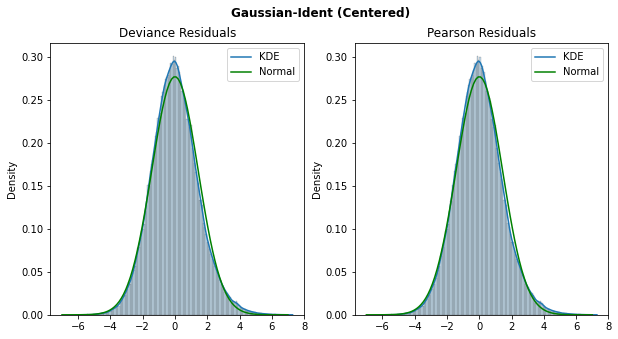

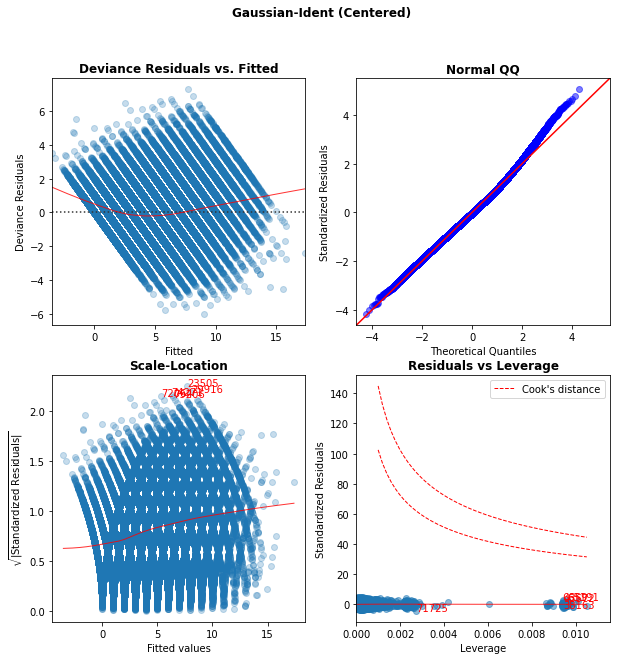

In [ ]:
# histogram of deviance residuals lkdf
_ = plotGLMResidualsHist(resBest,
                         plotTitle='Gaussian-Ident (Centered)')

# dianostic plots
_ = glmDiagnosticPlots(resBest,
                       figureTitle='Gaussian-Ident (Centered)')

### 4.2 Prediction Error

We want to make sure that the model is generalizes well, so we will compare the mean prediction error for each data set (training, testing, and validation).
Once again, take the sum of the absolute value of the difference between $Y_i$ and $\hat{Y}_i$ as the total prediction error. The mean of the prediction error should be the approximately the same across each data set. Significantly higher mean prediction errors in the testing and validation sets could indicate a problem with overfitting.

In [ ]:
print('Gaussian-Ident Model: Training Data')
errPred = sum(abs(df.loc[ixTr,'score'] - resBest.predict(sm.add_constant(df.loc[ixTr,xCols['xCols0Cent']]))))
errPredMean = errPred/len(ixTr)
print(f'\tTotal Prediction Error: {errPred}')
print(f'\tMean Prediction Error: {errPredMean}')

print('\nGaussian-Ident Model: Testing Data')
errPred = sum(abs(df.loc[ixTe,'score'] - resBest.predict(sm.add_constant(df.loc[ixTe,xCols['xCols0Cent']]))))
errPredMean = errPred/len(ixTe)
print(f'\tTotal Prediction Error: {errPred}')
print(f'\tMean Prediction Error: {errPredMean}')

print('\nGaussian-Ident Model: Validation Data')
errPred = sum(abs(df.loc[ixV,'score'] - resBest.predict(sm.add_constant(df.loc[ixV,xCols['xCols0Cent']]))))
errPredMean = errPred/len(ixV)
print(f'\tTotal Prediction Error: {errPred}')
print(f'\tMean Prediction Error: {errPredMean}')

Gaussian-Ident Model: Training Data
	Total Prediction Error: 118155.88736197155
	Mean Prediction Error: 1.127183539666217

Gaussian-Ident Model: Testing Data
	Total Prediction Error: 39351.957156903816
	Mean Prediction Error: 1.1262079204654518

Gaussian-Ident Model: Validation Data
	Total Prediction Error: 39541.39187854387
	Mean Prediction Error: 1.1316617119871748


## 5. Conclusions

### 5.1 GLM vs OLS

The Gaussian GLM with the identity linking function produced the best model for runs scored. If we compare this result to the results from the OLS model, we can see that the parameter estimates, and the standard errors are all generally in agreement. 

GLM results:

| **Parameter** | **$\hat{\beta}$** | **Std Err** | **95% CI LL** | **95% CI UL** |
|---------------|-------------------|-------------|---------------|---------------|
| const         | 4.4902            | 0.004       | 4.481         | 4.499         |
| abCent        | -0.1655           | 0.002       | -0.169        | -0.163        |
| 1bCent        | 0.6150            | 0.002       | 0.610         | 0.620         |
| 2bCent        | 0.8644            | 0.004       | 0.857         | 0.872         |
| 3bCent        | 1.1231            | 0.008       | 1.107         | 1.140         |
| 4bCent        | 1.4999            | 0.005       | 1.491         | 1.509         |
| sachCent      | -0.0543           | 0.006       | -0.067        | -0.042        |
| sacfCent      | 0.3191            | 0.010       | 0.300         | 0.338         |
| hbpCent       | 0.3498            | 0.009       | 0.333         | 0.367         |
| bbCent        | 0.3250            | 0.002       | 0.320         | 0.329         |
| ibbCent       | -0.1934           | 0.008       | -0.209        | -0.178        |
| kCent         | -0.0133           | 0.002       | -0.017        | -0.010        |
| sbCent        | 0.0517            | 0.005       | 0.042         | 0.062         |
| csCent        | -0.3627           | 0.008       | -0.379        | -0.346        |
| gidpCent      | -0.4129           | 0.006       | -0.424        | -0.402        |
| ciCent        | -0.4002           | 0.067       | -0.531        | -0.269        |
| oppWPCent     | 0.2189            | 0.008       | 0.203         | 0.235         |
| oppBalkCent   | 0.1620            | 0.022       | 0.119         | 0.205         |
| oppERRCent    | 0.5293            | 0.005       | 0.520         | 0.539         |
| oppPBCent     | 0.2192            | 0.015       | 0.189         | 0.249         |
| oppTPCent     | -0.7045           | 0.139       | -0.977        | -0.432        |

OLS results:

| **Parameter** | **$\hat{\beta}$** | **Std Err** | **95% CI LL** | **95% CI UL** |
|:-------------:|:---------------:|:-----------:|:-------------:|:-------------:|
|     const     |      4.4923     |    0.004    |     4.484     |     4.501     |
|     abCent    |     -0.1639     |    0.002    |     -0.167    |     -0.161    |
|     1bCent    |      0.6147     |    0.002    |     0.610     |     0.619     |
|     2bCent    |      0.8664     |    0.004    |     0.859     |     0.874     |
|     3bCent    |      1.1281     |    0.008    |     1.111     |     1.145     |
|     4bCent    |      1.5069     |    0.005    |     1.498     |     1.516     |
|    sachCent   |     -0.0551     |    0.006    |     -0.068    |     -0.043    |
|    sacfCent   |      0.3175     |    0.010    |     0.299     |     0.336     |
|     bbCent    |      0.3298     |    0.002    |     0.325     |     0.334     |
|    ibbCent    |     -0.1999     |    0.008    |     -0.216    |     -0.184    |
|     kCent     |     -0.0125     |    0.002    |     -0.016    |     -0.009    |
|     sbCent    |      0.0437     |    0.005    |     0.034     |     0.054     |
|     csCent    |     -0.3773     |    0.008    |     -0.394    |     -0.361    |
|   oppERRCent  |      0.5269     |    0.005    |     0.517     |     0.536     |
|   rbMiscCent  |      0.3377     |    0.009    |     0.321     |     0.354     |
|   xbMiscCent  |      0.2075     |    0.007    |     0.194     |     0.221     |
|  multOutsCent |     -0.4166     |    0.006    |     -0.427    |     -0.406    |

Given the similarity in the results, we can conclude that heteroskedasticity is the primary issue with this data set. A GLM can deal with this issue via a dispersion parameter, while heteroskedasticity in an OLS model is a departure from one of its primary assumptions. Despite this, however, OLS does produce an accurate and robust model.



### 5.2 Use Case

With a model that estimates the value of each on-field event in terms of run scoring, the next step is to apply it. One possible use case is to estimate the productivity of individual players. Hitters can be ranked by the number of runs they produce and pitchers by how few runs they allow. However, the residuals vs. fitted plot shows that the model works best when the fitted values are in the range (3,8). The model is based on per-game observations and the error increases as the fitted values increase. Applying the model to a full season of data, for instance, will produce wildly inaccurate results. 

To apply the model to larger blocks of data, perform the following steps.

1. Scale the data set down to the per-game level by dividing the number of at-bats by the mean number of at-bats per game, which, for this data set is 34.125 ab/game. 
2. Center the scaled data by subtracting the mean from each column.
3. Apply the model to the centered data.
4. Scale the predictions up to the original size using the scaling factor in  (1). 

For example, suppose we want to know who we the 25 most productive hitters in the 2006 season (playoffs included). Applying this procedure gives the following results.

| **First** | **Last** | **Team** | **Games** | **ab** | **1b** | **2b** | **3b** | **4b** | **sach** | **sacf** | **hbp** | **bb** | **ibb** | **k** | **sb** | **cs** | **gidp** | **ci** | **runsCreated** | **95% CI LL** | **95% CI UL** |
|:---------:|:--------:|:--------:|:---------:|:------:|:------:|:------:|:------:|:------:|:--------:|:--------:|:-------:|:------:|:-------:|:-----:|:------:|:------:|:--------:|:------:|:---------------:|:-------------:|:-------------:|
|    Ryan   |  Howard  |    PHI   |   160.0   |  582.0 |  98.0  |  25.0  |   1.0  |  58.0  |    0.0   |    6.0   |   9.0   |  71.0  |   37.0  | 181.0 |   0.0  |   0.0  |    9.0   |   0.0  |     123.793     |    123.044    |    124.541    |
|   Albert  |  Pujols  |    SLN   |   160.0   |  590.0 |  103.0 |  36.0  |   1.0  |  52.0  |    0.0   |    3.0   |   5.0   |  72.0  |   33.0  |  61.0 |   7.0  |   3.0  |   23.0   |   0.0  |     120.213     |    119.582    |    120.843    |
|   David   |   Ortiz  |    BOS   |   152.0   |  560.0 |  75.0  |  29.0  |   2.0  |  54.0  |    0.0   |    5.0   |   4.0   |  96.0  |   23.0  | 118.0 |   1.0  |   0.0  |   15.0   |   0.0  |     117.862     |    117.327    |    118.397    |
|   Chase   |   Utley  |    PHI   |   161.0   |  660.0 |  128.0 |  40.0  |   4.0  |  32.0  |    0.0   |    4.0   |   14.0  |  62.0  |   1.0   | 132.0 |  15.0  |   4.0  |   10.0   |   0.0  |     116.314     |    115.952    |    116.676    |
|   Grady   | Sizemore |    CLE   |   163.0   |  657.0 |  98.0  |  53.0  |  11.0  |  28.0  |    1.0   |    4.0   |   13.0  |  70.0  |   8.0   | 154.0 |  22.0  |   6.0  |    3.0   |   0.0  |     114.363     |    113.948    |    114.778    |
|   Carlos  |  Beltran |    NYN   |   151.0   |  550.0 |  67.0  |  40.0  |   1.0  |  44.0  |    1.0   |    7.0   |   4.0   |  98.0  |   6.0   | 104.0 |  21.0  |   3.0  |   10.0   |   0.0  |     114.147     |    113.718    |    114.577    |
|  Garrett  |  Atkins  |    COL   |   157.0   |  602.0 |  120.0 |  48.0  |   1.0  |  29.0  |    0.0   |    7.0   |   7.0   |  73.0  |   6.0   |  76.0 |   4.0  |   0.0  |   26.0   |   0.0  |     112.632     |    112.268    |    112.996    |
|   Lance   |  Berkman |    HOU   |   153.0   |  536.0 |  95.0  |  29.0  |   0.0  |  45.0  |    0.0   |    8.0   |   4.0   |  77.0  |   22.0  | 106.0 |   3.0  |   2.0  |   13.0   |   0.0  |     112.163     |    111.695    |    112.631    |
|   Derek   |   Jeter  |    NYA   |   159.0   |  642.0 |  161.0 |  43.0  |   3.0  |  15.0  |    7.0   |    4.0   |   12.0  |  66.0  |   4.0   | 106.0 |  34.0  |   6.0  |   19.0   |   0.0  |     110.726     |    110.302    |    111.149    |
|   Justin  |  Morneau |    MIN   |   160.0   |  604.0 |  120.0 |  38.0  |   1.0  |  36.0  |    0.0   |   11.0   |   5.0   |  44.0  |   9.0   |  93.0 |   3.0  |   3.0  |   12.0   |   0.0  |     109.207     |    108.841    |    109.572    |
|    Matt   | Holliday |    COL   |   156.0   |  605.0 |  112.0 |  45.0  |   5.0  |  34.0  |    0.0   |    3.0   |   15.0  |  44.0  |   3.0   | 110.0 |  10.0  |   5.0  |   24.0   |   0.0  |     108.324     |    107.939    |     108.71    |
|    Jim    |   Thome  |    CHA   |   144.0   |  491.0 |  73.0  |  26.0  |   0.0  |  42.0  |    0.0   |    7.0   |   6.0   |  95.0  |   12.0  | 147.0 |   0.0  |   0.0  |    7.0   |   0.0  |     107.157     |    106.704    |     107.61    |
|   Jason   |    Bay   |    PIT   |   160.0   |  573.0 |  97.0  |  29.0  |   3.0  |  35.0  |    0.0   |    9.0   |   8.0   |  93.0  |   9.0   | 158.0 |  11.0  |   2.0  |   15.0   |   0.0  |     106.361     |    105.967    |    106.755    |
|  Jermaine |    Dye   |    CHA   |   147.0   |  540.0 |  96.0  |  27.0  |   3.0  |  44.0  |    0.0   |    7.0   |   6.0   |  55.0  |   4.0   | 118.0 |   7.0  |   3.0  |   20.0   |   0.0  |      106.19     |    105.822    |    106.558    |
|   Travis  |  Hafner  |    CLE   |   129.0   |  454.0 |  66.0  |  31.0  |   1.0  |  42.0  |    0.0   |    2.0   |   7.0   |  84.0  |   16.0  | 111.0 |   0.0  |   0.0  |   12.0   |   1.0  |     104.588     |    104.142    |    105.035    |
|  Alfonso  |  Soriano |    WAS   |   160.0   |  649.0 |  91.0  |  41.0  |   2.0  |  46.0  |    2.0   |    3.0   |   9.0   |  51.0  |   16.0  | 160.0 |  42.0  |  17.0  |    3.0   |   0.0  |     104.517     |    103.929    |    105.105    |
|   Vernon  |   Wells  |    TOR   |   155.0   |  613.0 |  109.0 |  40.0  |   5.0  |  32.0  |    0.0   |    9.0   |   3.0   |  54.0  |   0.0   |  90.0 |  17.0  |   4.0  |   16.0   |   0.0  |     104.199     |    103.867    |     104.53    |
|   Miguel  |  Cabrera |    FLO   |   159.0   |  576.0 |  117.0 |  50.0  |   2.0  |  26.0  |    0.0   |    4.0   |   10.0  |  59.0  |   27.0  | 108.0 |   9.0  |   6.0  |   20.0   |   0.0  |     103.173     |     102.68    |    103.665    |
|   Carlos  |    Lee   |    MIL   |   162.0   |  625.0 |  112.0 |  37.0  |   1.0  |  37.0  |    0.0   |   11.0   |   2.0   |  52.0  |   6.0   |  65.0 |  19.0  |   2.0  |   23.0   |   0.0  |     101.777     |    101.372    |    102.182    |
|   Bobby   |   Abreu  |    NYA   |   160.0   |  563.0 |  109.0 |  42.0  |   2.0  |  15.0  |    2.0   |    9.0   |   3.0   |  120.0 |   6.0   | 140.0 |  30.0  |   6.0  |   17.0   |   0.0  |      101.25     |    100.791    |     101.71    |
|    Paul   |  Konerko |    CHA   |   153.0   |  568.0 |  114.0 |  30.0  |   0.0  |  35.0  |    0.0   |    9.0   |   8.0   |  57.0  |   3.0   | 104.0 |   1.0  |   0.0  |   25.0   |   0.0  |     101.083     |    100.724    |    101.443    |
|   Aramis  |  Ramirez |    CHN   |   157.0   |  594.0 |  93.0  |  38.0  |   4.0  |  38.0  |    0.0   |    7.0   |   9.0   |  46.0  |   4.0   |  63.0 |   2.0  |   1.0  |   17.0   |   0.0  |     100.814     |    100.452    |    101.176    |
|   Carlos  |  Delgado |    NYN   |   154.0   |  561.0 |  75.0  |  33.0  |   2.0  |  42.0  |    0.0   |   10.0   |   10.0  |  69.0  |   11.0  | 126.0 |   0.0  |   0.0  |   14.0   |   0.0  |     100.732     |    100.329    |    101.136    |
|    Mark   | Teixeira |    TEX   |   162.0   |  628.0 |  98.0  |  45.0  |   1.0  |  33.0  |    0.0   |    6.0   |   4.0   |  77.0  |   12.0  | 128.0 |   2.0  |   0.0  |   20.0   |   0.0  |     100.273     |     99.909    |    100.637    |
|   David   |  Wright  |    NYN   |   165.0   |  622.0 |  114.0 |  43.0  |   5.0  |  28.0  |    0.0   |    8.0   |   5.0   |  57.0  |   14.0  | 121.0 |  20.0  |   5.0  |   18.0   |   0.0  |      99.943     |     99.587    |     100.3     |

Alternatively, we could scale the data set down to the at-bat level prior to fitting the model. We have showed that the Gaussian GLM with the identity linking function produces valid results and this should apply to a linear transformation of the design matrix as well. If the model performs as expected, scaling up to a larger data block would be a simple matter of multiplying the predictions by the proper factor.